In [1]:
#   https://youtu.be/P6sfmUTpUmc?t=3659

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# character - integer mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build dataset
block_size = 3 # context length for characters

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and create new context
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
# training, dev and test sets
import random
random.seed(42)
random.shuffle(words)
# break points for a 80, 10, 10 split
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# MLP
n_embed = 10 #dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

In [9]:
# g = torch.Generator().manual_seed(2147483647)
# C = torch.randn((vocab_size, n_embed),             generator=g)
# W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
# b1 = torch.randn(n_hidden,                         generator=g)
# W2 = torch.randn((n_hidden, vocab_size),           generator=g)
# b2 = torch.randn(vocab_size,                       generator=g)

# parameters = [C, W1, b1, W2, b2]
# print(sum(p.nelement() for p in parameters)) # number of parameters total
# for p in parameters:
#     p.requires_grad = True

### #1.To improve the starting values
zero out the initial b2 values and adjust the W2 to much smaller values; creates inital logit values that are closer to 0 - the loss at the beginning is smaller and later adjustments can be made more easily.

In [10]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
# to demonstrate the learning problem of the neurons uncomment below
# W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
# b1 = torch.randn(n_hidden,                         generator=g)


W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01 #to decrease overall size of the logits
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

11897


In [11]:
# Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y -- ix is a tensor that indexes into tr
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors from C
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # hpreact too far from 0 --> neurons having trouble learning
    hpreact = embcat @ W1 + b1 # hidden layer activation
    
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step the learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: 
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


### Consideration of tanh effect on neurons: Brain Dead Neurons

The h values from tanh(hpreact) that are closest to 1 or -1 have a gradient of 1 and are passed through with no effect in backpropagation (see Micrograd for the tanh backpropagation function). 

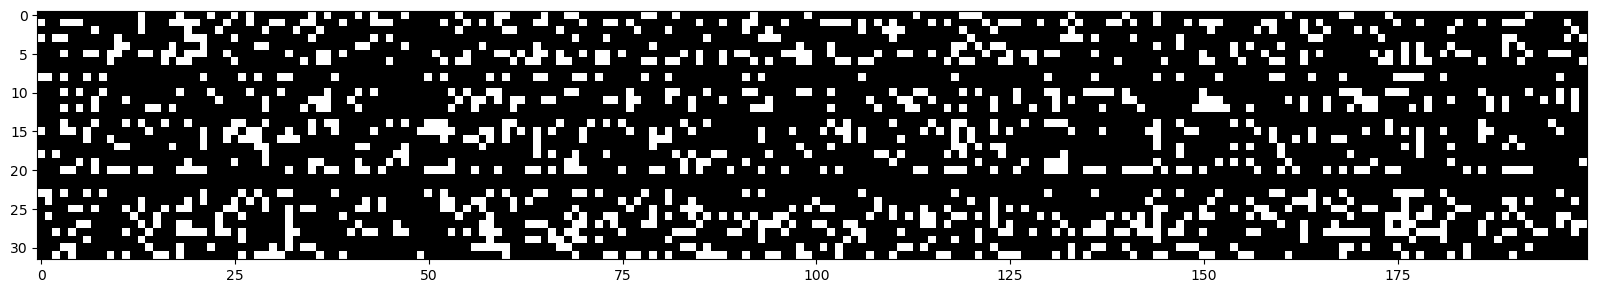

In [12]:
# 32 examples with 200 neurons
# How many activations are close to 1 or -1? 

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest'); # the absolute values of tanh that are closest
# to 1 or -1 ; boolean tensor - white if true, black if false

# UNCOMMENTED EXAMPLE in cell #1: the large amount of white means that the neuron would be destroyed 
# (made inconsequential) on backpropagation if a neuron is all white across examples would lead to a dead 
# neuron, never learn from backpropagation

# with the scalars on b1 and W1 the values are all below 1 or -1 --> no neuron has trouble learning

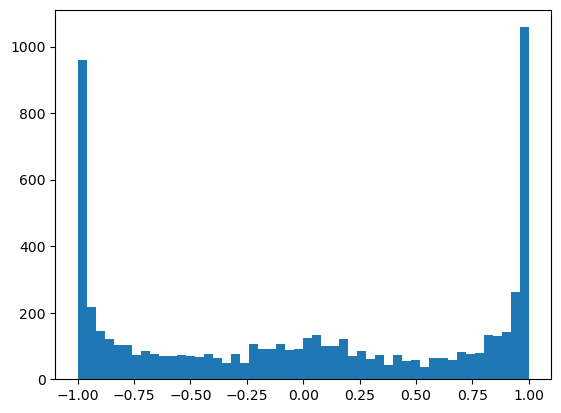

In [13]:
# examine the tanh function for possible optimizing: values near |1| update less frequently
plt.hist(h.view(-1).tolist(), 50);

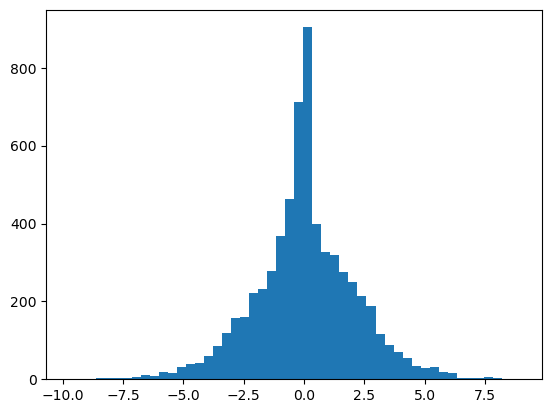

In [14]:
# distribution is broad; most values clustered --> tanh concentrations at -1 and 1
plt.hist(hpreact.view(-1).tolist(), 50);

In [15]:
# significant that the intial loss is 27 --> expect equal probability of each character
# the anticipated value if all initial values were equally likely
- torch.tensor(1/27.0).log()

tensor(3.2958)

In [16]:
# modify the values in block #1 above to come close to the above number
# logits should be closer to 0
logits[0]

tensor([-2.6747,  2.1230, -0.6957, -0.1797,  0.2563,  2.4494, -1.8891, -2.4445,
        -1.0200,  2.9168, -2.3774, -0.5807,  3.0092,  1.9834,  3.8758,  1.2065,
        -0.8338, -3.8638,  1.6995,  1.6316,  0.5563, -2.8111,  0.3735, -2.5028,
        -2.7555,  2.9825, -0.0861], grad_fn=<SelectBackward0>)

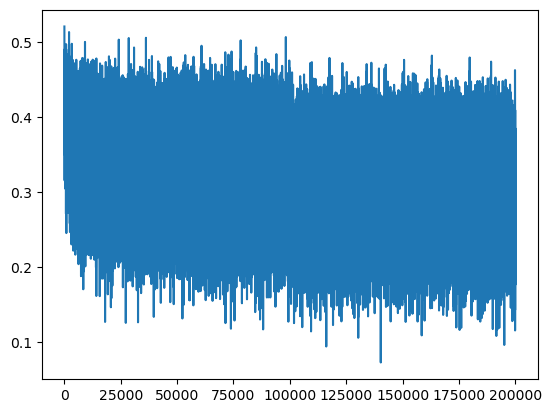

In [17]:
plt.plot(lossi) # removing the hockey-stick appearance means that the network is starting from a set
# of values that are closer to what is needed 

In [18]:
@torch.no_grad() # decorator to disable gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] #(N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026782989501953


### Loss Log:

In [19]:
# # original: with no adjustment to softmax or tanh
# train 2.125401020050049
# val 2.1713311672210693

# # fix softmax confidently wrong:
# train 2.069589138031006
# val 2.1310746669769287

# # fix tanh layer too saturated at init
# train 2.0355966091156006
# val 2.1026782989501953

In [20]:
# sampling from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass of the nn
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.


### Improve the starting point

In [21]:
# starting the network is very confidently wrong: 27.8817

# 4-dimensional example of the issue
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) * 10 # extreme values --> high loss
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-15.5937,   2.3640,  -0.3504,   8.2677]),
 tensor([4.3237e-11, 2.7216e-03, 1.8028e-04, 9.9710e-01]),
 tensor(8.6210))

## Tuning with more generalizable technique

In [22]:
# specific to tanh
# gain / sqrt fan_in
factor = (5/3)/(n_embed * block_size)**0.5 
factor

0.3042903097250923

In [23]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * factor # * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01 #to decrease overall size of the logits
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

11897


In [24]:
torch.randn(10000).std() # approaches 1
(torch.randn(10000) * 0.2).std()  # approaches the factor

tensor(0.1996)

Observe the standard deviations
tensor(0.0085) tensor(1.0025)
tensor(0.0006) tensor(0.9877)


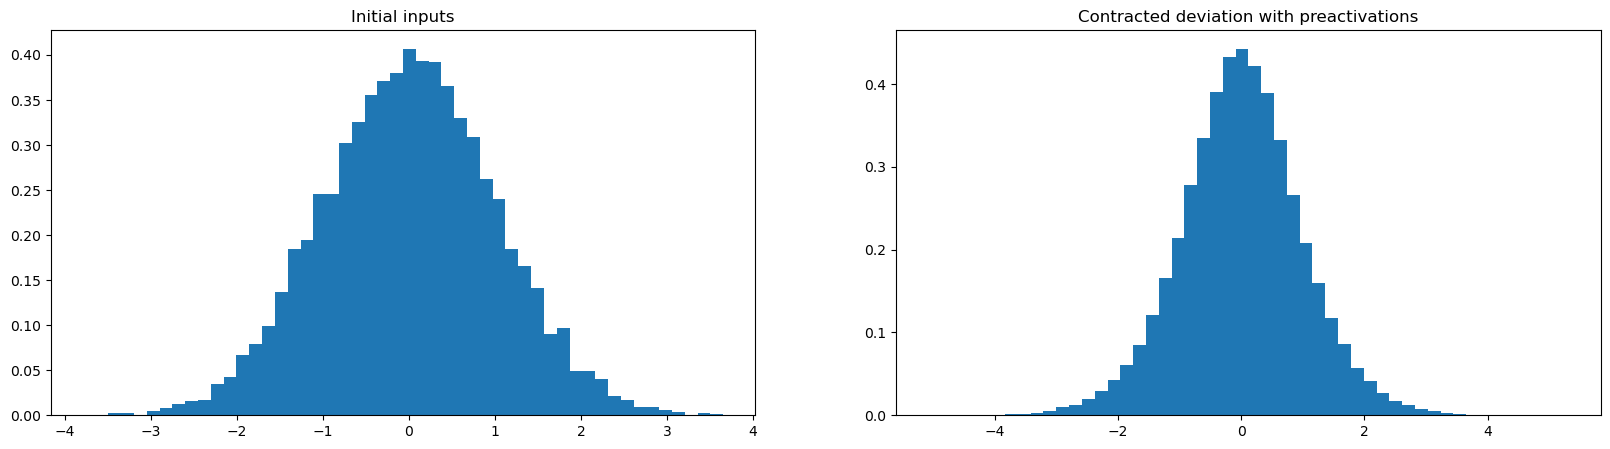

In [25]:
x = torch.randn(1000, 10)

# "normalize by the fan_in"
factor = 10**0.5 # fan_in; the number of inputs to the layer
w = torch.randn(10, 200) / factor # the division by the sqrt of 10 --> std close to 1
# compare other factors (0.2, 5, 3) with multiplication to see the effect on the std of the outputs
y = x @ w  # preactivations

print("Observe the standard deviations")
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.title("Initial inputs");
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.title("Contracted deviation with preactivations");

Need to scale the standard deviation of the preactivations down in order to be close to 1. PyTorch has the [Kaiming initialization](https://pytorch.org/docs/stable/nn.init.html#:~:text=torch.nn.init.kaiming_uniform_(tensor%2C%20a%3D0%2C%20mode%3D%27fan_in%27%2C%20nonlinearity%3D%27leaky_relu%27) as one of the most common techniques for initializing the weights. Details of [the parameters](https://stackoverflow.com/questions/42670274/how-to-calculate-fan-in-and-fan-out-in-xavier-initialization-for-neural-networks#:~:text=fan_in%20is%20the%20number%20of,outputs%20to%20a%20layer%20(6)). [Discussion](https://youtu.be/P6sfmUTpUmc?t=2124) of why a gain term is needed; to relieve the contraction of standard deviation imposed by the tanh function. 

In [26]:
# Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y -- ix is a tensor that indexes into tr
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors from C
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # hpreact too far from 0 --> neurons having trouble learning
    hpreact = embcat @ W1 + b1 # hidden layer activation
    
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step the learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: 
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [27]:
@torch.no_grad() # decorator to disable gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] #(N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    hpreact = embcat @ W1 + b1
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0376644134521484
val 2.106989622116089


These loss values are close to the same; the virtue is that this is more generalizable with the ***gain x sqrt(fan_in)*** factor. 

## Batch Normalization
standardize hidden states (normalize) to make them Guassian; common to include them for each linear layer and convolution in deeper networks
- jittering effect; depending on the random selection of values in the batch different mean and std will be seen --> jittering

In [28]:
# batch gain and batch bias = shift and scale features to be trained after initial initialization

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * factor # * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01 #to decrease overall size of the logits
b2 = torch.randn(vocab_size,                       generator=g) * 0

# terms to support batch normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# include the batch normailization gain and bias for optimization (backpropagation)
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

12297


In [29]:
# mean of the pre-activation values; mean of all values in the batch
hpreact.mean(0, keepdims=True).shape

torch.Size([1, 200])

In [30]:
# standard deviation of the vlaues
hpreact.std(0, keepdims=True).shape

torch.Size([1, 200])

In [31]:
# Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y -- ix is a tensor that indexes into tr
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors from C
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # hpreact too far from 0 --> neurons having trouble learning
    # normalizing the values of the pre-activations; this is for pre-initialization only; once backpropagation 
    # commences the shape and values should depart from Guassian --> scale and shift
    # scale and shift terms = bngains and bnbias; terms to capture optimization at backpropagation
    ########## Not as significant with a small network, with more layers becomes more useful #############
    ###########################################################
    hpreact = embcat @ W1 + b1 # hidden layer activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdims=True))/ hpreact.std(0, keepdims=True) + bnbias
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step the learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: 
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.2382
  20000/ 200000: 2.4296
  30000/ 200000: 2.4922
  40000/ 200000: 1.9450
  50000/ 200000: 2.4919
  60000/ 200000: 2.4512
  70000/ 200000: 2.0536
  80000/ 200000: 2.3732
  90000/ 200000: 2.2266
 100000/ 200000: 2.1449
 110000/ 200000: 2.4031
 120000/ 200000: 2.0916
 130000/ 200000: 2.5729
 140000/ 200000: 2.4819
 150000/ 200000: 2.2763
 160000/ 200000: 2.0418
 170000/ 200000: 1.8332
 180000/ 200000: 2.2360
 190000/ 200000: 1.9751


In [32]:
@torch.no_grad() # decorator to disable gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] #(N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdims=True))/ hpreact.std(0, keepdims=True) + bnbias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1608057022094727
val 2.1770615577697754


### Calculate the mean and std at each iteration (running)

In [33]:
# batch gain and batch bias = shift and scale features to be trained after initial initialization

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * factor # * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01 #to decrease overall size of the logits
b2 = torch.randn(vocab_size,                       generator=g) * 0

# terms to support batch normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# running, mean and std up to i
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# include the batch normailization gain and bias for optimization (backpropagation)
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

12297


In [34]:
# Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y -- ix is a tensor that indexes into tr
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors from C
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # hpreact too far from 0 --> neurons having trouble learning
    # normalizing the values of the pre-activations; this is for pre-initialization only; once backpropagation 
    # commences the shape and values should depart from Guassian --> scale and shift
    # scale and shift terms = bngains and bnbias; terms to capture optimization at backpropagation
    ########## Not as significant with a small network, with more layers becomes more useful #############
    hpreact = embcat @ W1 # + b1 # hidden layer activation; this bias term is now redundant due to bnbias
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True) # possible +epsilon
    
    hpreact = bngain * (hpreact - bnmeani)/ bnstdi + bnbias # possible +epsilon; encompasses previous 
                                                            # layer bias b1
    
    
    ############### Running mean and Std
    # each value is mostly what it was before with a small update based on the current iteration
    # outside of gradient update
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step the learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: 
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

## #2

In [ ]:
# calibrate the batch more at the begining of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @W1 + b1
    
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdims=True)
    bnstd = hpreact.std(0, keepdims=True)

By maintaining a running value for the mean and std a step (#2) to calculate the batch values after training is not needed

In [ ]:
# bnmean
# bnstd

In [ ]:
# bnmean_running
# bnstd_running

In [ ]:
# then use the mean and std from the entire training set to calculate the values in the batch

@torch.no_grad() # decorator to disable gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] #(N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    hpreact = embcat @ W1 + b1
    
    # use the mean and std from the entire dataset
    hpreact = bngain * (hpreact - bnmean_running)/ bnstd_running + bnbias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')